In [80]:
import new_feature_extraction as nfe
from new_feature_extraction import read_data
from new_feature_extraction import read_logistic_data
from new_feature_extraction import read_buy_rating_data
from new_feature_extraction import get_all_stocks_df
from new_feature_extraction import get_stock_df
from new_feature_extraction import featurize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
DIR = "/Users/rithikpothuganti/cs467/project/data"

In [81]:
# df = get_stock_df("/Users/rithikpothuganti/cs467/project/data/aapl.csv")
df = get_all_stocks_df()
df

,r_90d,r_180d,r_1y,r_2y,r_5y,r_10y,target_return,label,rating,Date,Close/Last
0,-0.046710,0.167282,0.175232,NaN,NaN,NaN,0.675448,1,4,03/18/2014,18.9800
1,-0.042886,0.142771,0.173160,NaN,NaN,NaN,0.669478,1,4,03/19/2014,18.9700
2,-0.040163,0.119146,0.144242,NaN,NaN,NaN,0.634004,1,4,03/20/2014,18.8800
3,-0.021594,0.140204,0.149155,NaN,NaN,NaN,0.632160,1,4,03/21/2014,19.0300
4,-0.017848,0.099315,0.169399,NaN,NaN,NaN,0.599688,1,4,03/24/2014,19.2600
...,...,...,...,...,...,...,...,...,...,...,...
20073,-0.216163,0.093557,0.178388,6.540874,15.443274,NaN,-0.333115,0,0,03/08/2022,274.8000
20074,-0.196443,0.137919,0.238191,8.649840,15.841854,NaN,-0.369768,0,0,03/09/2022,286.3233
20075,-0.164874,0.138577,0.184140,8.743142,15.451479,NaN,-0.341059,0,0,03/10/2022,279.4333
20076,-0.217968,0.070458,0.175024,10.009231,14.111525,NaN,-0.320563,0,0,03/11/2022,265.1166


In [82]:
features = ['r_90d', 'r_180d', 'r_1y', 'r_2y', 'r_5y', 'r_10y']
label = ['target_return', 'label', 'Date', 'Close/Last', 'rating']

X = df[features]
X.fillna(0, inplace=True)
y = df[label]

# Define the split indices
train_split_idx = int(len(X) * 0.7)
dev_split_idx = int(len(X) * 0.85)

# Train split
X_train_df, y_train_df = X.iloc[:train_split_idx], y.iloc[:train_split_idx]
train_dates = df["Date"].iloc[:train_split_idx]

# Dev (validation) split
X_dev_df, y_dev_df = X.iloc[train_split_idx:dev_split_idx], y.iloc[train_split_idx:dev_split_idx]
dev_dates = df["Date"].iloc[train_split_idx:dev_split_idx]

# Test split
X_test_df, y_test_df = X.iloc[dev_split_idx:], y.iloc[dev_split_idx:]
test_dates = df["Date"].iloc[dev_split_idx:]


/var/folders/ps/hbp83zj53cb60mmc6jt7f2s00000gn/T/ipykernel_81816/1272306311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [83]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
DEGREE = 1
X_train, y_train = read_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

linreg_model = LinearRegression()
reg = linreg_model.fit(X_train, y_train)  # Train the model
y_pred = linreg_model.predict(X_dev)
mse = mean_squared_error(y_dev, y_pred)
print("MSE:", mse)


MSE: 0.6783394039413426


In [84]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

DEGREE = 1
X_train, y_train = read_logistic_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_logistic_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

learning_rate = 0.001
sgd_clf = SGDClassifier(loss='log', learning_rate='constant', eta0=learning_rate, max_iter=200)
sgd_clf.fit(X_train_scaled, y_train)  # Train the model
print(sgd_clf.score(X_train_scaled, y_train))
w = sgd_clf.coef_.flatten()  # Weight vector

def evaluate(model, X, y, name):
    preds = model.predict(X)  # vector of size n
    acc = np.mean(preds == y)
    print(f'{name} accuracy: ', acc)

evaluate(sgd_clf, X_dev_scaled, y_dev, "logistic regression (SGD), dev")


0.7915895830368578
logistic regression (SGD), dev accuracy:  0.6769588313413014


/Users/rithikpothuganti/cs467/csci467-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class ReturnPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReturnPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.bn5 = nn.BatchNorm1d(hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.bn6 = nn.BatchNorm1d(hidden_size)
        self.fc7 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.tanh(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.fc7(x)
        x = F.softmax(x, dim=1)
        return x


In [86]:
DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)
# X_train = scaler.fit_transform(X_train)
# X_dev = scaler.transform(X_dev)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
# y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).view(-1, 1)
# # stats_2023_tensor = torch.tensor(stats_2023_values, dtype=torch.float32).to('cpu')

# # Create DataLoader objects
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=256, shuffle=False)

# test_data = TensorDataset(X_dev_tensor, y_dev_tensor)
# dev_loader = DataLoader(test_data, batch_size=256, shuffle=False)



In [90]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = len(np.unique(y_train))  # Number of classes
num_epochs = 70
batch_size = 256
learning_rate = 0.0005

# Convert data to tensors and create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

dev_dataset = TensorDataset(torch.tensor(X_dev, dtype=torch.float32), torch.tensor(y_dev, dtype=torch.long))
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Create the model, loss function, and optimizer
model = ReturnPredictor(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch [1/70], Loss: 1.5450
Validation Accuracy: 40.31%
Epoch [2/70], Loss: 1.4163
Validation Accuracy: 41.33%
Epoch [3/70], Loss: 1.3945
Validation Accuracy: 42.86%
Epoch [4/70], Loss: 1.3852
Validation Accuracy: 43.23%
Epoch [5/70], Loss: 1.3804
Validation Accuracy: 43.23%
Epoch [6/70], Loss: 1.3710
Validation Accuracy: 43.26%
Epoch [7/70], Loss: 1.3662
Validation Accuracy: 43.26%
Epoch [8/70], Loss: 1.3618
Validation Accuracy: 43.23%
Epoch [9/70], Loss: 1.3557
Validation Accuracy: 43.23%
Epoch [10/70], Loss: 1.3511
Validation Accuracy: 44.69%
Epoch [11/70], Loss: 1.3430
Validation Accuracy: 43.36%
Epoch [12/70], Loss: 1.3360
Validation Accuracy: 43.36%
Epoch [13/70], Loss: 1.3282
Validation Accuracy: 43.82%
Epoch [14/70], Loss: 1.3202
Validation Accuracy: 43.23%
Epoch [15/70], Loss: 1.3141
Validation Accuracy: 42.86%
Epoch [16/70], Loss: 1.3106
Validation Accuracy: 43.23%
Epoch [17/70], Loss: 1.3039
Validation Accuracy: 43.33%
Epoch [18/70], Loss: 1.2968
Validation Accuracy: 43.82%
E

In [91]:
# Neural network test accuracy
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

IndentationError: unexpected indent (39811618.py, line 9)

In [88]:
def r_squared(y_true, y_pred):
    ssr = torch.sum((y_true - y_pred)**2)
    sst = torch.sum((y_true - torch.mean(y_true))**2)
    r2 = 1 - (ssr / sst)
    return r2.item()

# Assuming the following variables are defined:
# val_loader: DataLoader for your validation or test dataset
# model: your trained neural network model
# device: the device to use (e.g., 'cpu' or 'cuda')

model.eval()
y_true = []
y_pred = []

def custom_round(value, possible_values=(-2, -1, 0, 1, 2)):
    return min(possible_values, key=lambda x: abs(x - value))


with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        outputs = model(inputs)
        outputs_np = outputs.numpy()
        print(outputs_np)
        # rounded_outputs_np = np.array([custom_round(value) for value in outputs_np])
        # Convert the rounded NumPy array back to a PyTorch tensor
        rounded_outputs = torch.tensor(rounded_outputs_np)
        y_true.append(targets)
        # y_pred.append(rounded_outputs)
        # print(rounded_outputs == targets)
        
# print(y_pred)
y_true = torch.cat(y_true).detach().numpy().flatten()
y_pred = torch.cat(y_pred).detach().numpy()
# print(y_true)

accuracy = np.sum(y_true == y_pred) / len(y_pred)

print(f"Neural Network Accuracy: {accuracy:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x12 and 6x64)

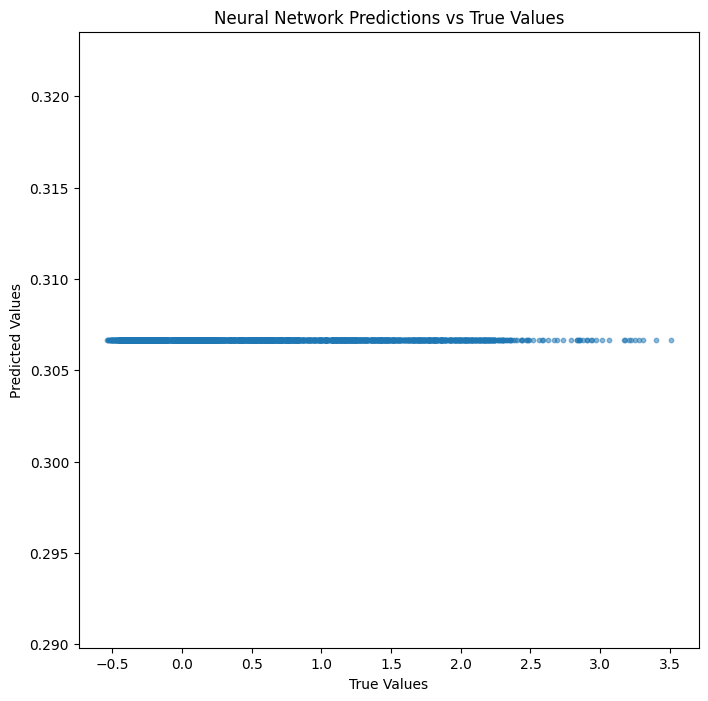

In [ ]:
import matplotlib.pyplot as plt

# Assuming the following variables are defined:
# val_loader: DataLoader for your validation or test dataset
# model: your trained neural network model
# device: the device to use (e.g., 'cpu' or 'cuda')

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        outputs = model(inputs)
        y_true.append(targets)
        y_pred.append(outputs)

y_true = torch.cat(y_true).detach().numpy()
y_pred = torch.cat(y_pred).detach().numpy()

# Plot the predicted values against the true values
plt.figure(figsize=(8,8))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network Predictions vs True Values')
plt.show()


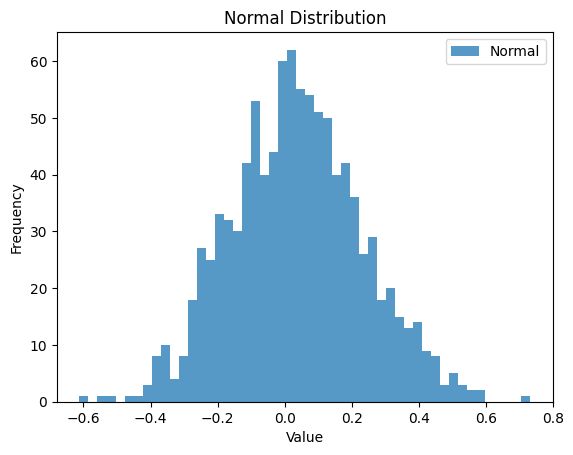

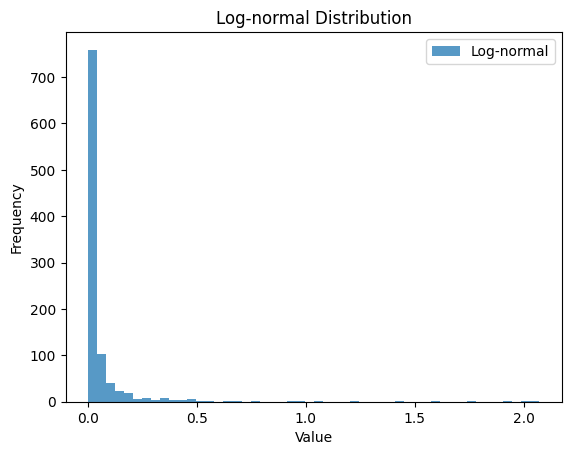

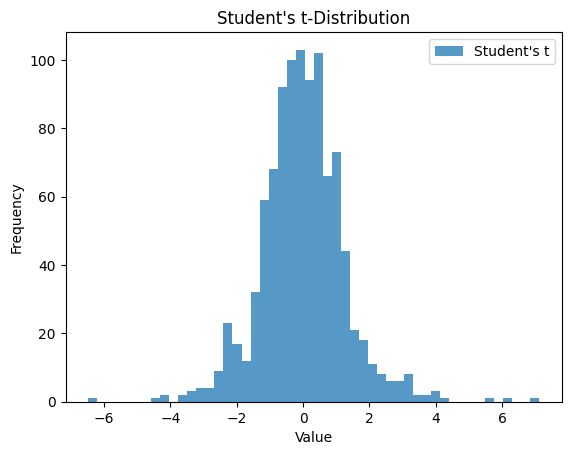

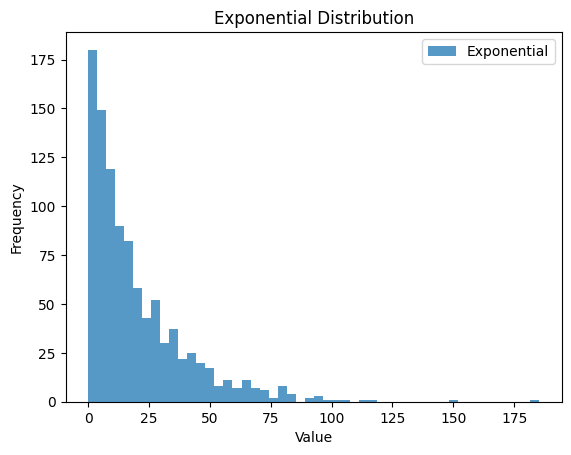

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Normal distribution
mean = 0.05
std_dev = 0.2
num_samples = 1000

normal_samples = np.random.normal(loc=mean, scale=std_dev, size=num_samples)

plt.hist(normal_samples, bins=50, alpha=0.75, label='Normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Normal Distribution')
plt.legend()
plt.show()

# Log-normal distribution
mu = np.log(mean**2 / np.sqrt(mean**2 + std_dev**2))
sigma = np.sqrt(np.log(1 + std_dev**2 / mean**2))

lognormal_samples = np.random.lognormal(mean=mu, sigma=sigma, size=num_samples)

plt.hist(lognormal_samples, bins=50, alpha=0.75, label='Log-normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log-normal Distribution')
plt.legend()
plt.show()

# Student's t-distribution
df = 5

t_samples = np.random.standard_t(df, size=num_samples)

plt.hist(t_samples, bins=50, alpha=0.75, label="Student's t")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Student's t-Distribution")
plt.legend()
plt.show()

# Exponential distribution
scale = 1 / mean

exponential_samples = np.random.exponential(scale=scale, size=num_samples)

plt.hist(exponential_samples, bins=50, alpha=0.75, label='Exponential')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Exponential Distribution')
plt.legend()
plt.show()
